# Discriminative Classification

### Preliminaries

- Goal 
  - Introduction to discriminative classification models
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 213 - 217 (Laplace approximation)  
    - Bishop pp. 217 - 220 (Bayesian logistic regression) 
    - [T. Minka (2005), Discriminative models, not discriminative training](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Minka-2005-Discriminative-models-not-discriminative-training.pdf)

###  Challenge: difficult class-conditional data distributions

Our task will be the same as in the preceding class on (generative) classification. But this time, the class-conditional data distributions look very non-Gaussian, yet the linear discriminative boundary looks easy enough:

In [1]:
using Pkg; Pkg.activate("../."); Pkg.instantiate();
using IJulia; try IJulia.clear_output(); catch _ end

  Activating project at `~/github/bertdv/BMLIP/lessons`


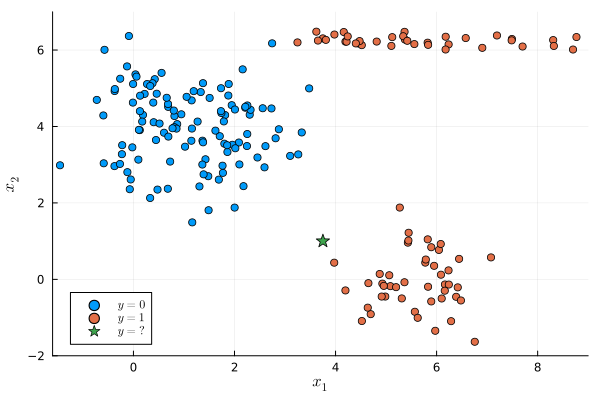

In [2]:
using Random; Random.seed!(1234);
# Generate dataset {(x1,y1),...,(xN,yN)}
# x is a 2-d feature vector [x_1;x_2]
# y ∈ {false,true} is a binary class label
# p(x|y) is multi-modal (mixture of uniform and Gaussian distributions)
using Plots, LaTeXStrings
include("./scripts/lesson8_helpers.jl")
N = 200
X, y = genDataset(N) # Generate data set, collect in matrix X and vector y
X_c1 = X[:,findall(.!y)]'; X_c2 = X[:,findall(y)]' # Split X based on class label
X_test = [3.75; 1.0] # Features of 'new' data point
function plotDataSet()
    result = scatter(X_c1[:,1], X_c1[:,2],markersize=4, label=L"y=0", xlabel=L"x_1", ylabel=L"x_2", xlims=(-1.6, 9), ylims=(-2, 7))
    scatter!(X_c2[:,1], X_c2[:,2],markersize=4, label=L"y=1")
    scatter!([X_test[1]], [X_test[2]], markersize=7, marker=:star, label=L"y=?") 
    return result  
end
plotDataSet()

###  Main Idea of Discriminative Classification 

- Again, a data set is given by  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$ with $x_n \in \mathbb{R}^M$ and $y_n \in \mathcal{C}_k$, with $k=1,\ldots,K$.

-  Sometimes, the precise assumptions of the (Gaussian-Categorical) generative model 
$$p(x_n,y_n\in\mathcal{C}_k|\theta) =  \pi_k \cdot \mathcal{N}(x_n|\mu_k,\Sigma)$$ 
clearly do not match the data distribution.

- Here's an **IDEA**! Let's model the posterior $$p(y_n\in\mathcal{C}_k|x_n)$$  *directly*, without any assumptions on the class densities.

### Model Specification for Bayesian Logistic Regression

- We will work this idea out for a 2-class problem. Assume a data set is given by  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$ with $x_n \in \mathbb{R}^M$ and $y_n \in \{0,1\}$.

- What model should we use for the posterior distribution $p(y_n \in \mathcal{C}_k|x_n)$?

##### Likelihood

- In Logistic Regression, we take inspiration from the generative approach, where the **softmax** function "emerged" as the posterior. Here, we **choose** the 2-class softmax function (which is called the [**logistic** function](https://en.wikipedia.org/wiki/Logistic_function)) with linear discrimination bounderies for the posterior class probability:
$$
p(y_n =1 \,|\, x_n, w) = \sigma(w^T x_n) \,.
$$
where $$\sigma(a) = \frac{1}{1+e^{-a}}$$ is the _logistic_ function.

- Clearly, it follows from this assumption that $p(y_n =0 \,|\, x_n, w) = 1- \sigma(w^T x_n)$.


<p style="text-align:center;"><img src="./figures/Figure4.9.png" width="500px"></p>

- (Bishop fig.4.9). The logistic function $\sigma(a) = 1/(1+e^{-a})$ (red), together with the <a id="scaled-probit">scaled probit function</a> $\Phi(\lambda a)$, for $\lambda^2=\pi/8$ (in blue). We will use this approximation later in the [Laplace approximation](#gaussian-cdf).


- Adding the other class ($y_n=0$) leads to the following posterior class distribution:
$$\begin{align*}
p(y_n \,|\, x_n, w) &= \mathrm{Bernoulli}\left(y_n \,|\, \sigma(w^T x_n) \right) \\
&= \sigma(w^T x_n)^{y_n} \left(1 - \sigma(w^T x_n)\right)^{(1-y_n)} \tag{B-4.89} \\
  &= \sigma\left( (2y_n-1) w^T x_n\right)
\end{align*}$$
  - Note that for the 3rd equality, we have made use of the fact that $\sigma(-a) = 1-\sigma(a)$.
  - Each of these three models in B-4.89 are **equivalent**. We mention all three notational options since they all appear in the literature.  

- For the data set $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$, the **likelihood function** for the parameters $w$ is then given by
$$
p(D|w) = \prod_{n=1}^N \sigma\left( (2y_n-1) w^T x_n\right)
$$

- This choice for the class posterior is called **logistic regression**, in analogy to **linear regression**:
$$\begin{align*}
p(y_n|x_n,w) &= \mathcal{N}(y_n|w^T x_n,\beta^{-1}) \quad &&\text{for linear regression} \\
p(y_n|x_n,w) &= \sigma\left( (2y_n-1) w^T x_n\right) &&\text{for logistic regression}
\end{align*}$$
 

 
- In the discriminative approach, the parameters $w$ are **not** structured into $\{\mu,\Sigma,\pi \}$. In principle they are "free" parameters for which we can choose any value that seems appropriate. This provides discriminative approach with more flexibility than the generative approach. 
  

##### Prior 

- In *Bayesian* logistic regression, we often add a **Gaussian prior on the weights**: 
$$\begin{align*}
p(w) = \mathcal{N}(w \,|\, m_0, S_0) \tag{B-4.140}
\end{align*}$$

### Some Notes on the Model

- Note that for generative classification, for the sake of simplicity, we used maximum likelihood estimation for the model parameters. In this lesson on discriminative classification, we specify both a prior and likelihood function for the parameters $w$, which allows us to compute a Bayesian posterior for the weights. In principle, we could have used Bayesian parameter estimation for the generative classification model as well (but the math is not suited for a introductory lesson).  

- In the optional paper by [T. Minka (2005)](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Minka-2005-Discriminative-models-not-discriminative-training.pdf), you can read how the model assumptions for discriminative classification can be re-interpreted as a special generative model (this paper not for exam). 
- As an exercise, please check that for logistic regression with $p(y_n =1 \,|\, x_n, w) = \sigma(w^T x_n)$, the **discrimination boundary**, which can be computed by
 $$\frac{p(y_n\in\mathcal{C}_1|x_n)}{p(y_n\in\mathcal{C}_0|x_n)} \overset{!}{=} 1$$
is a straight line, see [Exercises](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/exercises/Exercises-Classification.ipynb). 


### <a id="#logistic-regression-posterior">Parameter Inference</a>

- After model specification, the rest follows by application of probability theory.

- The posterior for the weights follows by Bayes rule
$$\begin{align*}
\underbrace{p(w \,|\, D)}_{\text{posterior}} &\propto  p(w) p(D|w) \\ &= \underbrace{\mathcal{N}(w \,|\, m_0, S_0)}_{\text{prior}} \cdot \underbrace{\prod_{n=1}^N \sigma\left( (2y_n-1) w^T x_n\right)}_{\text{likelihood}} \tag{B-4.142}
\end{align*}$$

- In principle, Bayesian inference is done now! 

- Unfortunately, the posterior $p(w \,|\, D)$ is not Gaussian and the evidence $p(D)$ is also not analytically computable. (We will deal with this later).

### Application: the predictive distribution

- For a new data point $x_\bullet$, the predictive distribution for $y_\bullet$ is given by 
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &= \int p(y_\bullet = 1 \,|\, x_\bullet, w) \, p(w\,|\, D) \,\mathrm{d}w \\
  &= \int \sigma(w^T x_\bullet) \, p(w\,|\, D) \,\mathrm{d}w \tag{B-4.145}
\end{align*}$$

- After substitution of $p(w | D)$ from B-4.142, we have closed-form expressions for both the posterior $p(w|D)$ and the predictive distribution $p(y_\bullet = 1 \mid x_\bullet, D)$. Unfortunately, these expressions contain integrals that are not analytically computable. 

- Many methods have been developed to approximate the integrals in order to get analytical or numerical solutions. Here, we present the **Laplace approximation**, which is one of the simplest methods with broad applicability to Bayesian calculations.

### The Laplace Approximation

- The central idea of the Laplace approximation is to approximate a (possibly unnormalized) distribution $f(z)$ by a Gaussian distribution $q(z)$. 


- The Laplace approximation usually serves one or both of the following two purposes: 
  1. To approximate a posterior distribution without closed-form expression by a Gaussian distribution.
  2. To approximate (part of) the integrand in an integral with purpose to get an analytical solution for the integral.

##### Example 

<p style="text-align:center;"><img src="./figures/Figure4.14a.png" width="500px"></p>

- (Bishop fig.4.14a). Laplace approximation (in red) to the distribution $p(z)\propto \exp(-z^2/2)\sigma(20z+4)$, where $\sigma(a)=1/(1+e^{-a})$. The Laplace approximation is centered on the mode of $p(z)$.   

### Working out the Laplace Approximation 

- Assume that we want to approximate a distribution $f(z)$ by a Gaussian distribution $q(z)$.

- Note that, if $q(z)$ is a Gaussian distribution, then $\log q(z)$ is a second-order polynomial in $z$, so we will find the Gaussian by fitting a parabola to $\log f(z)$. 



##### estimation of mean 

- The mean ($z_0$) of $q(z)$ is placed on the mode of $\log f(z)$, i.e., 

$$z_0 = \arg\max_z \left( \log f(z)\right)  \tag{B-4.126}$$ 

##### estimation of precision matrix

- Note that since $\nabla \log f(z) = \frac{1}{f(z)}\nabla f(z)$ and the gradient $\nabla \left. f(z) \right|_{z=z_0}$ vanishes at the mode $z=z_0$, we can (Taylor) expand $\log f(z)$ around $z=z_0$ as 
$$\begin{align*}
\log f(z) &\approx \log f(z_0) + \overbrace{\left(\nabla \log f(z_0)\right)^T (z-z_0)}^{=0 \text{ at }z=z_0} + \ldots \\
&\qquad + \frac{1}{2} (z-z_0)^T \left(\nabla \nabla \log f(z_0)\right) (z-z_0) \\
  &= \log f(z_0) - \frac{1}{2} (z-z_0)^T A (z-z_0) \tag{B-4.131}
\end{align*}$$
where the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) $A$ is defined by
$$
A = - \nabla \nabla \left. \log f(z) \right|_{z=z_0} \tag{B-4.132}
$$

##### Laplace approximation construction

- After taking exponentials in eq. B-4.131, we obtain

$$
f(z) \approx f(z_0) \exp\left( - \frac{1}{2} (z-z_0)^T A (z-z_0)\right) 
$$

- We can now identify $q(z)$ as
$$
q(z) = \mathcal{N}\left( z\,|\,z_0, A^{-1}\right) \tag{B-4.134}
$$
with $z_0$ and $A$ defined by eqs. B-4.126 and B-4.132. 

- All we have done up to now is approximate a function $f(z)$ by a Gaussian $q(z)$. This procedure is called the **Laplace Approximation**. Often, the required integrals (for Bayesian marginalization) can be approximately computed if we replace $f(z)$ by $q(z)$. 

### Bayesian Logistic Regression with the Laplace Approximation

- Let's get back to the challenge of computing the predictive class distribution (B-4.145) for Bayesian logistic regression. We first work out the Gaussian Laplace approximation $q(w)$ to the [posterior weight distribution](#logistic-regression-posterior) 
$$\begin{align*}
\underbrace{p(w | D)}_{\text{posterior}} \propto  \underbrace{\mathcal{N}(w \,|\, m_0, S_0)}_{\text{prior}} \cdot \underbrace{\prod_{n=1}^N \sigma\left( (2y_n-1) w^T x_n\right)}_{\text{likelihood}}  \tag{B-4.142}
\end{align*}$$

##### A Gausian Laplace approximation to the weights posterior 

- Since we have a differentiable expression for $\log p(w | D)$, it is straightforward to compute the gradient and Hessian (for [proof, see optional slide](#gradient-hessian)):
$$\begin{align*}
\nabla_w \log p(w | D) &= S_0^{-1}\cdot \left(m_0-w\right) + \sum_n (2y_n-1) (1-\sigma_n) x_n \\
\nabla\nabla_w \log p(w | D) &= -S_0^{-1} - \sum_n \sigma_n (1-\sigma_n) x_n x_n^T \tag{B-4.143}
\end{align*}$$
where we used shorthand $\sigma_n$ for $\sigma\left( (2y_n-1) w^T x_n\right)$. 

- We can now use the gradient $\nabla_w \log p(w | D)$ to find the **mode** $w_{N}$ of $\log p(w|D)$ (eg by some gradient-based optimization procedure) and then use the Hessian $\nabla\nabla_w \log p(w | D)$ to get the variance of $q(w)$, leading to a <a id="Laplace-posterior-logistic-regression">**Gaussian approximate weights posterior**</a>:
$$
q(w) = \mathcal{N}\left(w\,|\, w_{N}, S_N\right) \tag{B-4.144}
$$
with
$$
S_N^{-1} = S_0^{-1} + \sum_n \sigma_n (1-\sigma_n) x_n x_n^T \tag{B-4.143}
$$

### Using the Laplace-approximated parameter posterior to evaluate the predictive distribution 

- In the analytically unsolveable expressions for evidence and the predictive distribution (estimating the class of a new observation), we proceed with using the Laplace approximation to the weights posterior. For a new observation $x_\bullet$, the class probability is now
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &= \int p(y_\bullet = 1 \,|\, x_\bullet, w) \cdot p(w\,|\, D) \,\mathrm{d}w \\
  &\approx \int p(y_\bullet = 1 \,|\, x_\bullet, w) \cdot \underbrace{q(w)}_{\text{Gaussian}} \,\mathrm{d}w \\
  &= \int \sigma(w^T x_\bullet) \cdot \mathcal{N}\left(w \,|\, w_N, S_N\right) \,\mathrm{d}w \tag{B-4.145}
\end{align*}$$

- This looks better but we need two more clever tricks to evaluate this expression. 
  1. First, note that $w$ appears in $\sigma(w^T x_\bullet)$ as an inner product, so through substitution of $a:=w^T x_\bullet$, the expression simplifies to an integral over the scalar $a$ (see Bishop for derivation):
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &\approx \int \sigma(a) \, \mathcal{N}\left(a\,|\, \mu_a, \sigma_a^2\right) \,\mathrm{d}a \qquad &&\text{(B-4.151)}\\
\mu_a  &= w^T_{N} x_\bullet \qquad &&\text{(B-4.149)}\\
\sigma_a^2 &= x^T_\bullet S_N x_\bullet \qquad &&\text{(B-4.150)}
\end{align*}$$
  2. Secondly, while the integral of the product of a logistic function with a Gaussian is not analytically solvable, the integral of the product of a Gaussian cumulative distribution function (CDF, also known as the [probit function](#scaled-probit)) with a Gaussian _does_ have a closed-form solution. Fortunately, 
$$\Phi(\lambda a) \approx \sigma(a)$$
with the <a id="gaussian-cdf">Gaussian</a> CDF $\Phi(x)= \frac{1}{\sqrt(2\pi)}\int_{-\infty}^{x}e^{-t^2/2}\mathrm{d}t$, $ \lambda^2= \pi / 8 $ and $\sigma(a) = 1/(1+e^{-a})$. 
  Thus, substituting $\Phi(\lambda a)$ with $ \lambda^2= \pi / 8 $ for $\sigma(a)$ leads to 

$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &=  \int \sigma(w^T x_\bullet) \cdot p(w|D) \,\mathrm{d}w  \\ 
&\approx \int \underbrace{\Phi(\lambda a)}_{\text{probit function}} \cdot \underbrace{\mathcal{N}\left(a\,|\, \mu_a, \sigma_a^2\right)}_{\text{Gaussian}} \,\mathrm{d}a \\ 
&= \Phi\left( \frac{\mu_a}{\sqrt(\lambda^{-2} +\sigma_a^2)}\right) \tag{B-4.152}
\end{align*}$$

- We now have an approximate but **closed-form expression for the predictive class distribution for a new observation** with a Bayesian logistic regression model.  

- Note that, by [Eq.B-4.143](#Laplace-posterior-logistic-regression), the variance $S_N$ (and consequently $\sigma_a^2$) for the weight vector depends on the distribution of the training set. Large uncertainty about the weights (in areas with little training data and uninformative prior variance $S_0$) increases $\sigma_a^2$ and takes the posterior class probability eq. B-4.152 closer to $0.5$. Does that make sense?

- Apparently, the Laplace approximation leads to a closed-form solutions for Bayesian logistic regression (although admittedly, the derivation is no walk in the park). 

- Exam guide: The derivation of closed-form expression eq. B-4.152 for the predictive class distribution requires clever tricks and is therefore not something that you should be able to reproduce at the exam without assistance. You should understand the Laplace Approximation though and be able to work out simpler examples.  

###  ML Estimation for Discriminative Classification 
 
- Rather than the computationally involved Laplace approximation for Bayesian inference, in practice, discriminative classification is often executed through maximum likelihood estimation. 

- With the usual 1-of-K encoding scheme for classes ($y_{nk}=1$ if $x_n \in \mathcal{C}_k$, otherwise $y_{nk}=0$), the log-likelihood for a $K$-dimensional discriminative classifier is 

     $$\begin{align*}
    \mathrm{L}(\theta) &= \log \prod_n \prod_k {p(\mathcal{C}_k|x_n,\theta)}^{y_{nk}} \\
    &= \log \prod_n \prod_k \Bigg(\underbrace{\frac{e^{\theta_k^T x_n}}{ \sum_j e^{\theta_j^T x_n}}}_{\text{softmax function}}\Bigg)^{y_{nk}} \\
    &= \sum_n \sum_k y_{kn} \log \big( \frac{e^{\theta_k^T x_n}}{ \sum_j e^{\theta_j^T x_n}} \big)
     \end{align*}$$

  

   
- Computing the gradient $\nabla_{\theta_k} \mathrm{L}(\theta)$ leads to (for [proof, see optional slide below](#ML-for-LG)) 

$$
\nabla_{\theta_k} \mathrm{L}(\theta) = \sum_n \underbrace{\big( \underbrace{y_{nk}}_{\text{target}} - \underbrace{\frac{e^{\theta_k^T x_n}}{ \sum_j e^{\theta_j^T x_n}}}_{\text{prediction}} \big)}_{\text{prediction error}}\cdot x_n 
$$

  
- Compare this to the [gradient for _linear_ regression](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Regression.ipynb#regression-gradient):

$$
\nabla_\theta \mathrm{L}(\theta) =  \sum_n \left(y_n - \theta^T x_n \right)  x_n
$$

- In both cases

$$
\nabla_\theta \mathrm{L} =  \sum_n \left( \text{target}_n - \text{prediction}_n \right) \cdot \text{input}_n 
$$

- The parameter vector $\theta$ for logistic regression can be estimated through iterative gradient-based adaptation. E.g. (with iteration index $i$),
$$
\hat{\theta}^{(i+1)} =  \hat{\theta}^{(i)} + \eta \cdot \left. \nabla_\theta   \mathrm{L}(\theta)  \right|_{\theta = \hat{\theta}^{(i)}}
$$
  - Note that, while in the Bayesian approach we get to update $\theta$ with [**Kalman-gain-weighted** prediction errors](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/The-Gaussian-Distribution.ipynb#precision-weighted-update) (which is optimal), in the maximum likelihood approach, we weigh the prediction errors with **input** values (which is less precise).

### Code Example: ML Estimation for Discriminative Classification

- Let us perform ML estimation of $w$ on the data set from the introduction. To allow an offset in the discrimination boundary, we add a constant 1 to the feature vector $x$. We only have to specify the (negative) log-likelihood and the gradient w.r.t. $w$. Then, we use an off-the-shelf optimisation library to minimize the negative log-likelihood.

- We plot the resulting maximum likelihood discrimination boundary. For comparison we also plot the ML discrimination boundary obtained from the [code example in the generative Gaussian classifier lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Generative-Classification.ipynb#code-generative-classification-example).

P(C1|x•,θ) = 0.4016963543791772


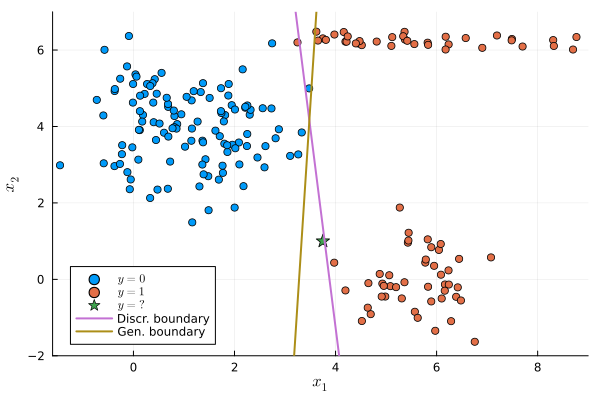

In [3]:
using Optim # Optimization library

y_1 = zeros(length(y))# class 1 indicator vector
y_1[findall(y)] .= 1
X_ext = vcat(X, ones(1, length(y))) # Extend X with a row of ones to allow an offset in the discrimination boundary

# Implement negative log-likelihood function
function negative_log_likelihood(θ::Vector)
    # Return negative log-likelihood: -L(θ)
    p_1 = 1.0 ./ (1.0 .+ exp.(-X_ext' * θ))   # P(C1|X,θ)
    return -sum(log.( (y_1 .* p_1) + ((1 .- y_1).*(1 .- p_1))) ) # negative log-likelihood
end

# Use Optim.jl optimiser to minimize the negative log-likelihood function w.r.t. θ
results = optimize(negative_log_likelihood, zeros(3), LBFGS())
θ = results.minimizer

# Plot the data set and ML discrimination boundary
plotDataSet()
p_1(x) = 1.0 ./ (1.0 .+ exp(-([x;1.]' * θ)))
boundary(x1) = -1 ./ θ[2] * (θ[1]*x1 .+ θ[3])

generative_boundary = buildGenerativeDiscriminationBoundary(X, y)


x_test = [3.75;1.0]
println("P(C1|x•,θ) = $(p_1(x_test))")
plot!([-2., 10.], boundary.([-2., 10.]), label="Discr. boundary", linewidth=2)
plot!([-2.,10.], generative_boundary.([-2,10]), label="Gen. boundary", linewidth=2)

- The generative model gives a bad result because the feature distribution of one class is clearly non-Gaussian: the model does not fit the data well. 

- The discriminative approach does not suffer from this problem because it makes no assumptions about the feature distribition $p(x|y)$, it just estimates the conditional class distribution $p(y|x)$ directly.

### Why be Bayesian?

-  Why should you embrace the Bayesian approach to logistic regression? After all, Maximum Likelihood for logistic regression seems simpler.

- Still, consider the following:
  - Bayesian logistic regression with the Laplace approximation ultimately leads to very simple analytic rules. Moreover, modern probabilistic programming languages and packages are able to automate the above inference derivations. (We just do them here to gain insight in difficult inference processes.)
  - Bayesian logistic regression offers the option to compute model evidence. 
  - Bayesian logistic regression processes uncertainties, e.g., in places where almost no data is observed, the posterior class probability will pull back to the prior class probability rather than predicting some arbitrary probability.
 


### Recap Classification

<table>
<tr> <td></td><td style="text-align:center"><b>Generative</b></td> <td style="text-align:center"><b>Discriminative (ML)</b></td> </tr> 

<tr> <td>1</td><td>Like <b>density estimation</b>, model joint prob.
$$p(\mathcal{C}_k) p(x|\mathcal{C}_k) = \pi_k \mathcal{N}(\mu_k,\Sigma)$$</td> <td>Like (linear) <b>regression</b>, model conditional
$$p(\mathcal{C}_k|x,\theta)$$</td> </tr>

<tr> <td>2</td><td>Leads to <b>softmax</b> posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
with <b>structured</b> $\theta$</td> <td> <b>Choose</b> also softmax posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
but now with 'free' $\theta$</td> </tr>

<tr> <td>3</td><td>For Gaussian $p(x|\mathcal{C}_k)$ and multinomial priors,
$$\hat \theta_k  = \left[ {\begin{array}{c}
   { - \frac{1}{2} \mu_k^T \sigma^{-1} \mu_k  + \log \pi_k}  \\
   {\sigma^{-1} \mu_k }  \\
\end{array}} \right]$$
<b>in one shot</b>.</td> <td>Find $\hat\theta_k$ through gradient-based adaptation
$$\nabla_{\theta_k}\mathrm{L}(\theta) = \sum_n \Big( y_{nk} - \frac{e^{\theta_k^T x_n}}{\sum_{k^\prime} e^{\theta_{k^\prime}^T x_n}} \Big)\, x_n$$ </td> </tr>
</table>

## <center> OPTIONAL SLIDES </center>

###  <a id="gradient-hessian">Proof of gradient and Hessian for Laplace Approximation of Posterior</a>

- We will start with the posterior
$$\begin{align*}
\underbrace{p(w | D)}_{\text{posterior}} \propto  \underbrace{\mathcal{N}(w \,|\, m_0, S_0)}_{\text{prior}} \cdot \underbrace{\prod_{n=1}^N \sigma\big( \underbrace{(2y_n-1) w^T x_n}_{a_n}\big)}_{\text{likelihood}}  \tag{B-4.142}
\end{align*}$$
from which it follows that
$$\begin{align*}
\log p(w | D) \propto  -\frac{1}{2}\log |S_0| -\frac{1}{2} (w-m_0)^T S_0^{-1} (w-m_0) +\sum_n \log \sigma\left( a_n\right) 
\end{align*}$$
and the gradient
$$\begin{align*}
\nabla_{w}\log p(w | D) &\propto   \underbrace{S_0^{-1} (m_0-w)}_{\text{SRM-5b}} +\sum_n \underbrace{\frac{1}{\sigma(a_n)}}_{\frac{\partial \log \sigma(a_n)}{\partial \sigma(a_n)}} \cdot \underbrace{\sigma(a_n) \cdot (1-\sigma(a_n))}_{\frac{\partial \sigma(a_n)}{\partial a_n}} \cdot \underbrace{(2y_n-1)x_n}_{\frac{\partial a_n}{\partial w} \text{ (see SRM-5a)}}    \\
&=   S_0^{-1} (m_0-w) + \sum_n (2y_n-1) (1-\sigma(a_n)) x_n \quad \text{(gradient)}
 \end{align*}$$
where we used  $\sigma^\prime(a) = \sigma(a)\cdot (1-\sigma(a))$.

- For the Hessian, we continue to differentiate the transpose of the gradient, leading to
$$\begin{align*}
\nabla\nabla_{w}\log p(w | D) &=  \nabla_{w} \left(S_0^{-1} (m_0-w)\right)^T - \sum_n (2y_n-1) x_n \nabla_{w}\sigma(a_n)^T \\ &=  -S_0^{-1} - \sum_n (2y_n-1) x_n \cdot \underbrace{\sigma(a_n)\cdot (1-\sigma(a_n))}_{\frac{\partial \sigma(a_n)^T}{\partial a_n^T}}\cdot \underbrace{(2y_n-1) x_n^T}_{\frac{\partial a_n^T}{\partial w}} \\
&= -S_0^{-1} - \sum_n \sigma(a_n)\cdot (1-\sigma(a_n))\cdot x_n x_n^T \quad \text{(Hessian)}
\end{align*}$$
since $(2y_n-1)^2=1$ for $y_n \in \{0,1\}$.



###  <a id="ML-for-LG">Proof of Derivative of Log-likelihood for Logistic Regression</a>


- The Log-likelihood is $
    \mathrm{L}(\theta) = \log \prod_n \prod_k {\underbrace{p(\mathcal{C}_k|x_n,\theta)}_{p_{nk}}}^{y_{nk}} = \sum_{n,k} y_{nk} \log p_{nk}$

     
- Use the fact that the softmax $\phi_k \equiv e^{a_k} / {\sum_j e^{a_j}}$ has analytical derivative:

$$ \begin{align*}
 \frac{\partial \phi_k}{\partial a_j} &= \frac{(\sum_j e^{a_j})e^{a_k}\delta_{kj}-e^{a_j}e^{a_k}}{(\sum_j e^{a_j})^2} = \frac{e^{a_k}}{\sum_j e^{a_j}}\delta_{kj} - \frac{e^{a_j}}{\sum_j e^{a_j}} \frac{e^{a_k}}{\sum_j e^{a_j}}\\
     &= \phi_k \cdot(\delta_{kj}-\phi_j)
 \end{align*}$$

<!---
%    -  Again we try to minimize the cross-entropy ($\sum_{nk} y_{nk} \log \frac{y_{nk}}{p_{nk}}$) between the data `targets' $t_{nk}$ and the model outputs $p_{nk}$.
--->

 -  Take the derivative of $\mathrm{L}(\theta)$ (or: how to spend a hour ...)
$$\begin{align*} 
\nabla_{\theta_j} \mathrm{L}(\theta) &= \sum_{n,k} \frac{\partial \mathrm{L}_{nk}}{\partial p_{nk}} \cdot\frac{\partial p_{nk}}{\partial a_{nj}}\cdot\frac{\partial a_{nj}}{\partial \theta_j} \\
  &= \sum_{n,k} \frac{y_{nk}}{p_{nk}} \cdot p_{nk} (\delta_{kj}-p_{nj}) \cdot x_n \\
  &= \sum_n \Big( y_{nj} (1-p_{nj}) -\sum_{k\neq j} y_{nk} p_{nj} \Big) \cdot x_n \\
  &= \sum_n \left( y_{nj} - p_{nj} \right)\cdot x_n \\
  &= \sum_n \Big( \underbrace{y_{nj}}_{\text{target}} - \underbrace{\frac{e^{\theta_j^T x_n}}{\sum_{j^\prime} e^{\theta_{j^\prime}^T x_n}}}_{\text{prediction}} \Big)\cdot x_n 
\end{align*}$$

In [3]:
open("../../styles/aipstyle.html") do f
    display("text/html", read(f,String))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->